# Laboratory of Computational Physics mod.B

## First assignment

### Group name: 
LoCPdown
### Components:
* Campesan Giulia (2027592)
* Faorlin Tommaso (2021857)
* Marcomini Alessandro (2024286)

In [1]:
#import

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
import pandas as pd

The first function to be minimised is the following one:
$$f(x,y)=b\left(1-e^{-\frac{1}{2}(x^2+y^2)}\right)+\frac{1}{2}\,q\,(-x^3+y)^2$$


Below we report the plot of the function in the $[-3:3] \times [-3:3]$ cartesian domain. As one can notice, the function shows a global minimum in $(0,0)$. 

Our goal is to test to which extent different techniques manage to reach the minimum starting from various points of the domain.

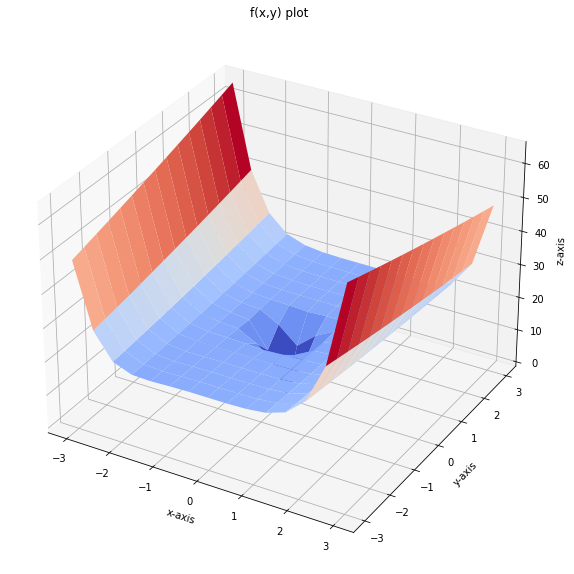

In [2]:
#parameters
b = 20
q = 0.1
w = 10
n_epochs = 5000

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

#defining the first function
def surf_1(x, y, b, q, w):
    return b*(1-np.exp(-.5*w*(x**2+y**2)))+.5*q*(-x**3+y)**2

#defining the gradients of the first function along the two directions
def grad_surf_1(params): 
    x=params[0]
    y=params[1]
    grad_x= b*np.exp(-0.5*w*(x**2+y**2))*w*x-3*q*x**2*(-x**3+y)
    grad_y= b*np.exp(-0.5*w*(x**2+y**2))*w*y+q*(-x**3+y)
    return [grad_x,grad_y]

X = np.linspace(-3, 3, 15)
Y = np.linspace(-3, 3, 15)
xm, ym = np.meshgrid(X, Y)
Z = surf_1(xm, ym, b, q, w)

surf = ax.plot_surface(xm,ym,Z, cmap = cm.coolwarm)

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.title("f(x,y) plot")

plt.show()

In the following cell we import the gradient descent methods from the notebook we were given. 
The next paragraphs describe our analysis towards the best definition of learning rates. According to the tuning procedure results (showed in the following cells), we have set the $\eta$ parameter values as:
* gd, gd with momentum, RMS prop: $\eta=10^{-2}$,
* NAG, Adam: $\eta=10^{-3}$.


The values for $\beta$, $\gamma$ and $\epsilon$ are the one reported in the paper [Mehta]:
* $\beta$=0.99,
* $\gamma$=0.9,
* $\epsilon=10^{-8}$.

The number of epoch we finally set for this run is $n = 5000$. We also tried setting lower and higher values to observe how this parameter affects convergence. Overall, the final value provides a sufficient term to retrieve a significant analysis without affecting too much our computational resources.

In [3]:
def gd(grad, init, n_epochs, eta = 10**-2, noise_strength = 0):
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def gd_with_mom(grad, init, n_epochs, eta = 10**-2, gamma=0.9, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def NAG(grad, init, n_epochs, eta = 10**-3, gamma=0.9, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def rms_prop(grad, init, n_epochs, eta= 10**-2, beta=0.9, epsilon=10**-8, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                        
                        
def adams(grad, init, n_epochs, eta = 10**-3, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj


fun_dict = {
    'vanilla'  : gd,
    'momentum' : gd_with_mom,
    'nag'      : NAG,
    'rms'      : rms_prop,
    'adam'    : adams
    }

In the following windows we provide an analysis of the behaviour of the implemented algorithms while changing the learning rate: this is the analysis that allowed us to set the optimal $\eta$ values.

## Vanilla gradient descent tuning 

In [8]:
#initialising lists
#trajectories = []    
avgs = []
init = [0,0]

#defining a list of different learning parameters
etas = [10**-4, 10**-3, 10**-2]
for eta in tqdm(etas):
    avg = []
    traj_list = []
    for i in range(len(X)):
        for j in range(len(Y)):
            init[0] = X[i]
            init[1] = Y[j]
            init = np.asarray(init)
            traj_list.append(gd(grad_surf_1, init, n_epochs, eta))
            
    traj_list = np.array(traj_list).reshape(len(X),len(Y),n_epochs+1,2)
    #trajectories.append(traj_list)


    for e in range(n_epochs+1):
        temp = 0
        for i in range(len(X)):
            for j in range(len(Y)):
                x,y = traj_list[i][j][e]
                temp += surf_1(x, y, b, q, w)
        temp /= (len(X)*len(Y))
        avg.append(temp)
    avgs.append(avg)

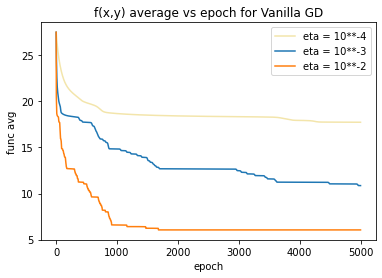

In [9]:
plt.plot(avgs[0], label = 'eta = 10**-4')
plt.plot(avgs[1], label = 'eta = 10**-3')
plt.plot(avgs[2], label = 'eta = 10**-2')

plt.title('f(x,y) average vs epoch for Vanilla GD')
plt.xlabel('epoch')
plt.ylabel('func avg')
plt.legend()

plt.show()

As one may notice, the best learning rate for this algorithm is $\eta = 10^{-2}$, which provides a quick yet stable descent for the gradient.

## Gradient descent with momentum tuning 

In [10]:
#defining a list of different learning parameters
etas = [10**-4, 10**-3, 10**-2]
avgs=[]
for eta in tqdm(etas):
    avg = []
    traj_list = []
    init = [0,0]
    for i in range(len(X)):
        for j in range(len(Y)):
            init[0] = X[i]
            init[1] = Y[j]
            init = np.asarray(init)
            traj_list.append(gd_with_mom(grad_surf_1, init, n_epochs, eta))
            
    traj_list = np.array(traj_list).reshape(len(X),len(Y),n_epochs+1,2)
    #trajectories.append(traj_list)


    for e in range(n_epochs+1):
        temp = 0
        for i in range(len(X)):
            for j in range(len(Y)):
                x,y = traj_list[i][j][e]
                temp += surf_1(x, y, b, q, w)
        temp /= (len(X)*len(Y))
        avg.append(temp)
    avgs.append(avg)

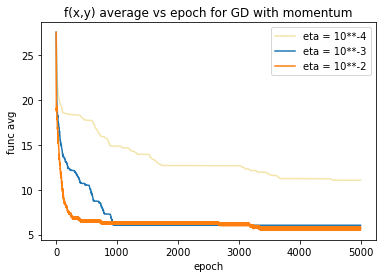

In [11]:
plt.plot(avgs[0], label = 'eta = 10**-4')
plt.plot(avgs[1], label = 'eta = 10**-3')
plt.plot(avgs[2], label = 'eta = 10**-2')

plt.title('f(x,y) average vs epoch for GD with momentum')
plt.xlabel('epoch')
plt.ylabel('func avg')
plt.legend()

plt.show()

For the gradient descent with momentum both $\eta = 10^{-3}$ and $\eta = 10^{-2}$ provide a fast descent towards the minimum. In the end, we choose the last value because of its stability and overall better performance.

## NAG gradient descent tuning

In [12]:
#defining a list of different learning parameters
etas = [10**-4, 10**-3, 10**-2]
avgs=[]
for eta in tqdm(etas):
    avg = []
    traj_list = []
    init = [0,0]
    for i in range(len(X)):
        for j in range(len(Y)):
            init[0] = X[i]
            init[1] = Y[j]
            init = np.asarray(init)
            traj_list.append(NAG(grad_surf_1, init, n_epochs, eta))
            
    traj_list = np.array(traj_list).reshape(len(X),len(Y),n_epochs+1,2)
    #trajectories.append(traj_list)


    for e in range(n_epochs+1):
        temp = 0
        for i in range(len(X)):
            for j in range(len(Y)):
                x,y = traj_list[i][j][e]
                temp += surf_1(x, y, b, q, w)
        temp /= (len(X)*len(Y))
        avg.append(temp)
    avgs.append(avg)

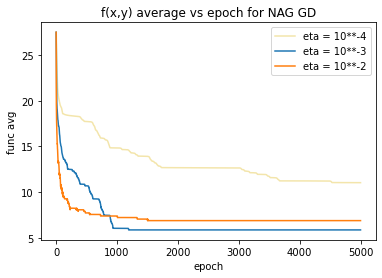

In [13]:
plt.plot(avgs[0], label = 'eta = 10**-4')
plt.plot(avgs[1], label = 'eta = 10**-3')
plt.plot(avgs[2], label = 'eta = 10**-2')

plt.title('f(x,y) average vs epoch for NAG GD')
plt.xlabel('epoch')
plt.ylabel('func avg')
plt.legend()

plt.show()

For the NAG algorithm we can observe a whole fashion of behaviours: while the smaller learning rate leads to a slow constant descrease of the mean function, the biggest one rockets to convergence but does not reach an optimum value. As for $\eta = 10^{-3}$ instead, we can notice how the gradient descent is not the fastest but nevertheless provides a better convergence. This is the reason to consider it as the best learning rate.

## RMSprop tuning

In [16]:
#defining a list of different learning parameters
etas = [10**-4, 10**-3, 10**-2]
avgs=[]
for eta in tqdm(etas):
    avg = []
    traj_list = []
    init = [0,0]
    for i in range(len(X)):
        for j in range(len(Y)):
            init[0] = X[i]
            init[1] = Y[j]
            init = np.asarray(init)
            traj_list.append(rms_prop(grad_surf_1, init, n_epochs, eta))
            
    traj_list = np.array(traj_list).reshape(len(X),len(Y),n_epochs+1,2)
    


    for e in range(n_epochs+1):
        temp = 0
        for i in range(len(X)):
            for j in range(len(Y)):
                x,y = traj_list[i][j][e]
                temp += surf_1(x, y, b, q, w)
        temp /= (len(X)*len(Y))
        avg.append(temp)
    avgs.append(avg)

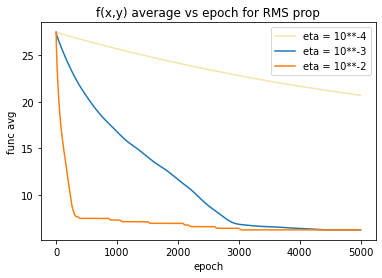

In [17]:
plt.plot(avgs[0], label = 'eta = 10**-4', color = '#f3e5ab')
plt.plot(avgs[1], label = 'eta = 10**-3')
plt.plot(avgs[2], label = 'eta = 10**-2')

plt.title('f(x,y) average vs epoch for RMS prop')
plt.xlabel('epoch')
plt.ylabel('func avg')
plt.legend()

plt.show()

For the RMS prop method we notice how $\eta=10^{-2}$ leads to the fastest and closer to convergence descent and will be then from now on used for this method.

##  ADAM tuning

In [19]:
#defining a list of different learning parameters
etas = [10**-4, 10**-3, 10**-2]
avgs=[]
for eta in tqdm(etas):
    avg = []
    traj_list = []
    init = [0,0]
    for i in range(len(X)):
        for j in range(len(Y)):
            init[0] = X[i]
            init[1] = Y[j]
            init = np.asarray(init)
            traj_list.append(adams(grad_surf_1, init, n_epochs, eta))
            
    traj_list = np.array(traj_list).reshape(len(X),len(Y),n_epochs+1,2)
    


    for e in range(n_epochs+1):
        temp = 0
        for i in range(len(X)):
            for j in range(len(Y)):
                x,y = traj_list[i][j][e]
                temp += surf_1(x, y, b, q, w)
        temp /= (len(X)*len(Y))
        avg.append(temp)
    avgs.append(avg)

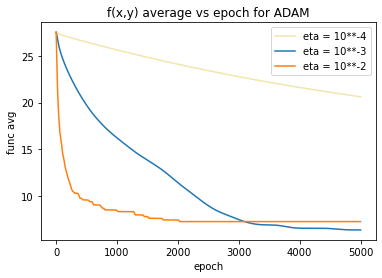

In [20]:
plt.plot(avgs[0], label = 'eta = 10**-4', color = '#f3e5ab')
plt.plot(avgs[1], label = 'eta = 10**-3')
plt.plot(avgs[2], label = 'eta = 10**-2')

plt.title('f(x,y) average vs epoch for ADAM')
plt.xlabel('epoch')
plt.ylabel('func avg')
plt.legend()

plt.show()

For the ADAM algorithm both $\eta = 10^{-2}$ and $\eta = 10^{-3}$ provide a good enough descent towards the minimum. In the end, we choose the last value because of its stability and overall better performance.

## Final comparison

In [21]:
trajectories = []
avgs = []

for func_key in tqdm(fun_dict):
    print('Gradient: ', func_key)
    traj_list = []
    avg = []
    init = [0,0]
    for i in range(len(X)):
        for j in range(len(Y)):
            init[0] = X[i]
            init[1] = Y[j]
            init = np.asarray(init)
            
            traj_list.append(fun_dict[func_key](grad_surf_1, init, n_epochs))
    
   
    
    traj_list = np.array(traj_list).reshape(len(X),len(Y),n_epochs+1,2)
    trajectories.append(traj_list)
    

    for e in range(n_epochs+1):
        temp = 0
        for i in range(len(X)):
            for j in range(len(Y)):
                x,y = traj_list[i][j][e]
                temp += surf_1(x, y, b, q, w)
        temp /= (len(X)*len(Y))
        avg.append(temp)
    avgs.append(avg)
   

Gradient:  vanilla
Gradient:  momentum
Gradient:  nag
Gradient:  rms
Gradient:  adam



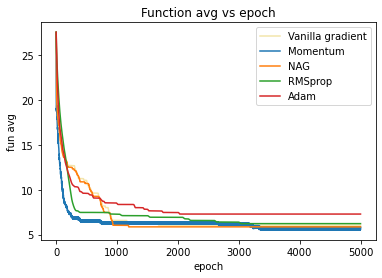

In [22]:
plt.plot(avgs[0], label = 'Vanilla gradient', color = '#f3e5ab')
plt.plot(avgs[1], label = 'Momentum')
plt.plot(avgs[2], label = 'NAG')
plt.plot(avgs[3], label = 'RMSprop')
plt.plot(avgs[4], label = 'Adam')

plt.title('Function avg vs epoch')
plt.xlabel('epoch')
plt.ylabel('fun avg')
plt.legend()

plt.show()

According to the learning rates we set, this is the best overall performance for the five algorithms under review on the given function: while some of them (e.g. GD with momentum and RMS prop) come to convergence after a relatively small amount of epochs, the whole set actually provides constant result after about 3000 iterations. In this particular case the gradient descent with momentum reaches the best performance in terms of minimum average function. NAG and RMSprop provide substantial good results as well. The ADAM algorithm is the one providing a slightly worst performance, landing at a little higher average value. This is reasonably due to some initial conditions that fail to converge to the minimum, keeping higher the overall mean of the function.

In the following window we provide a visual evolution of the descent towards the minimum for each algorithm, taking into account a subset of 5 different initial conditions.

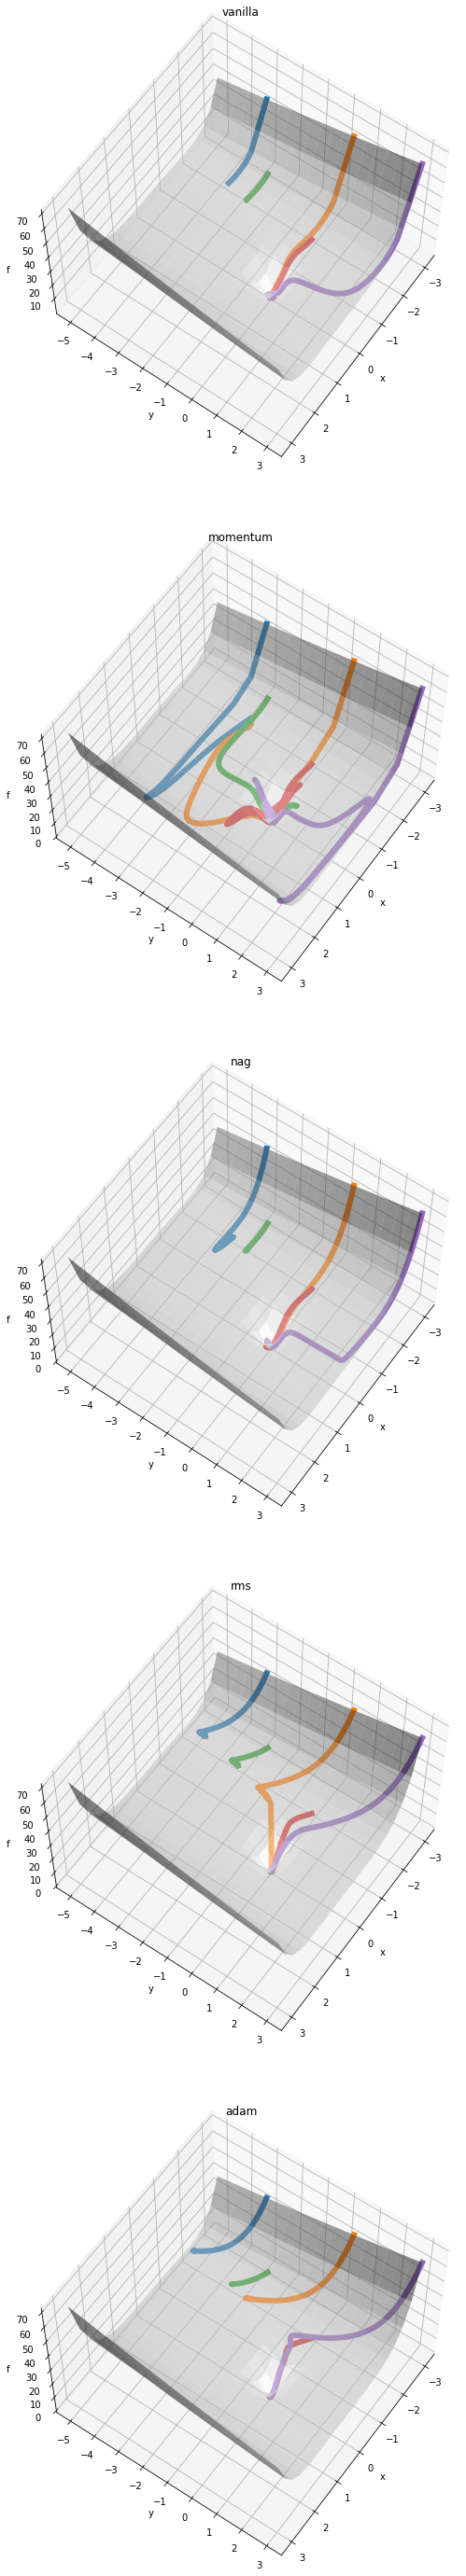

In [23]:
fig = plt.figure(figsize=(15,50))
method_list = []
for key in fun_dict:
    method_list.append(key)

for i in range(5):
    
    ax = fig.add_subplot(5,1, i+1, projection='3d') 
    ax.set_title(method_list[i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f')
    
    sample_traj_1 = []
    sample_traj_2 = []
    sample_traj_3 = []
    sample_traj_4 = []
    sample_traj_5 = []
    
    method=i
    
    points = [[0,0],[0,8],[2,2],[4,8],[0,14]]
    
    for point in range(len(points)):
        sample_traj = []
        xs = []
        ys = []
        zs = []
        for k in range(len(trajectories[method][0][0])):

            x = [trajectories[method][points[point][0]][points[point][1]][k][0]]
            y = [trajectories[method][points[point][0]][points[point][1]][k][1]]            

            temp = surf_1(trajectories[method][points[point][0]][points[point][1]][k][0],
                          trajectories[method][points[point][0]][points[point][1]][k][1], b, q, w)
            z = [temp]
            
            zs.append(z[0])
            xs.append(x[0])
            ys.append(y[0])
            
            point_to_plot = np.concatenate((np.asarray(x), np.asarray(y), np.asarray(z)), axis=0)
            sample_traj.append(point_to_plot)
            
        ax.plot(xs,ys,zs,linewidth=6.0)
    
    X = np.linspace(-3, 3, 20)
    Y = np.linspace(-5, 3, 20)
    xm, ym = np.meshgrid(X, Y)
    Z = surf_1(xm, ym, b, q, w)

    surf = ax.plot_surface(xm,ym,Z, cmap = cm.binary, alpha=0.5)
    ax.view_init(60, 35)
    
plt.show()   

The behaviour of each algorithm reflects the expectations we foresee observing the slopes of the average functions vs the epochs. 
As for the vanilla gradient, we notice that in the given amount of iteractions the evolution of starting points with an $y$ coordinate close to the minimum point reaches convergence, while other points slide properly along the slopes but do not have enough inertia to move towards the hole. Similar thing occurs for the NAG algorithm, where the paths designed by evolutions are correct but not long enough to make it to the minimum. On the other hand, the gradient with momentum depicts a typical behaviour of a ball let falling on an hillside, rolling accordingly to its momentum and eventually falling to the minimum: the purple line is a clear example of this, as it is the orange line where we see an hypothetical ball rolling down on the hole, entering its horizon and finally exiting performing a curve because of its own inertia. This algorithm's was in fact the best performance overall. 
The tracks of parameters for the RMSprop are similar to vanilla gradient and NAG ones: we can observe how the blue and green lines will supposedly follow the behaviour of the orange one, but did not have enough time to converge. As for the ADAM algorithm instead the evoluion of points far from the local minimum brings them away from such region: this is the reason for the average value of the function to be still high after 5000 epochs.

# Optional point

We now exploit another function which has the characteristic of multiple local minima close to the absolute one in order to analyse the unstability of ADAM algorithm. The function under investigation is the following:

$$f(x,y)=1 + \frac{1}{2} q\left( x^2 + y^2 \right) - \cos \left(2\pi\left( xy - y^2 \right) \right)$$

A plot of this function is reported below.

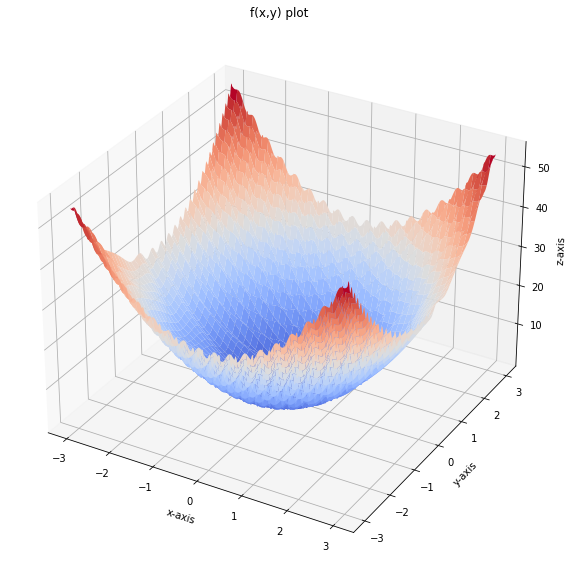

In [24]:
#function parameter
q2 = 6

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

def surf_2(x, y, q2):
    return 1.+.5*q2*(x**2+y**2)-np.cos(2*np.pi*(x*y-y**2))

def grad_surf_2(params):
    x=params[0]
    y=params[1]
    grad_x= q2*x+2*np.pi*y*np.sin(2*np.pi*(x*y-y**2))
    grad_y= q2*y+2*np.pi*(x-2.*y)*np.sin(2*np.pi*(x*y-y**2))
    return [grad_x,grad_y]

Xp = np.linspace(-3, 3, 500)
Yp = np.linspace(-3, 3, 500)
xm, ym = np.meshgrid(Xp, Yp)
Z = surf_2(xm, ym, q2)

surf = ax.plot_surface(xm,ym,Z, cmap = cm.coolwarm)

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

plt.title("f(x,y) plot")

plt.show()

We exploit the technique used above: we consider a $[-3,3]\times[-3,3]$ grid and computed the mean of the trajectories obtained using as starting point each point in the grid in order to find the best performing learning rate after comparing various of them.

In [25]:
trajectories = []
avgs = []
n_epochs = 3000
l_rates = [10**-6,10**-5,10**-4,10**-3,10**-2, 10**-1]
X = np.linspace(-3, 3, 15)
Y = np.linspace(-3, 3, 15)

#external cycle over learning rates
for rate in tqdm(l_rates):
    print('Learning rate: ', rate)
    traj_list = []
    avg = []
    init = [0,0]
    
    #looping over cartesian points 
    #cycle over X
    for i in range(len(X)):
        #cycle over Y
        for j in range(len(Y)):
            init[0] = X[i]
            init[1] = Y[j]
            init = np.asarray(init)
            traj_list.append(adams(grad_surf_2, init,n_epochs, rate))
            
       
    traj_list = np.array(traj_list).reshape(len(X),len(Y),n_epochs+1,2)
    trajectories.append(traj_list)
    
    #loop for average calculation
    for e in tqdm(range(n_epochs+1)):
        temp = 0
        for i in range(len(X)):
            for j in range(len(Y)):
                x,y = traj_list[i][j][e]
                temp += surf_2(x, y, q2)
        temp /= len(X)*len(Y)
        avg.append(temp)
    avgs.append(avg)

Learning rate:  1e-06



Learning rate:  1e-05



Learning rate:  0.0001



Learning rate:  0.001



Learning rate:  0.01



Learning rate:  0.1


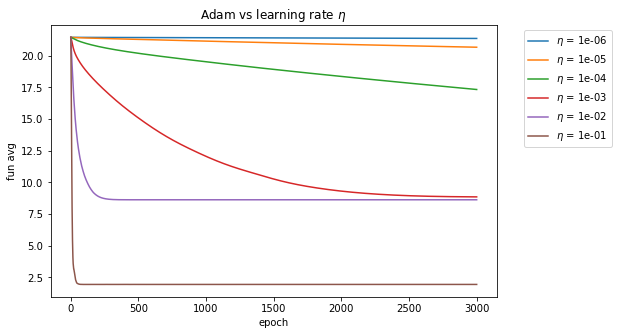

In [43]:
from matplotlib._mathtext_data import (latex_to_bakoma, latex_to_standard,
                                       tex2uni, latex_to_cmex,
                                       stix_virtual_fonts)
x_epoch = np.arange(1,n_epochs+2,1)

fig = plt.figure(figsize=(8,5))
plt.plot(x_epoch,avgs[0], label = '$\eta$ = 1e-06')
plt.plot(x_epoch,avgs[1], label = '$\eta$ = 1e-05')
plt.plot(x_epoch,avgs[2], label = '$\eta$ = 1e-04')
plt.plot(x_epoch,avgs[3], label = '$\eta$ = 1e-03')
plt.plot(x_epoch,avgs[4], label = '$\eta$ = 1e-02')
plt.plot(x_epoch,avgs[5], label = '$\eta$ = 1e-01')


plt.legend(bbox_to_anchor=(1.05, 1))
plt.xlabel('epoch')
plt.ylabel('fun avg')
plt.title('Adam vs learning rate $\eta$ ')

plt.show()

Looking at the plot above, we can infer that for this function $\eta=10^{-1}$ turns out to be the best learning rate. Further on, we will then focus on it for our computations.


In the following cells we show the trajectory evolution for different initial conditions, both through 3d and 2d plots. 

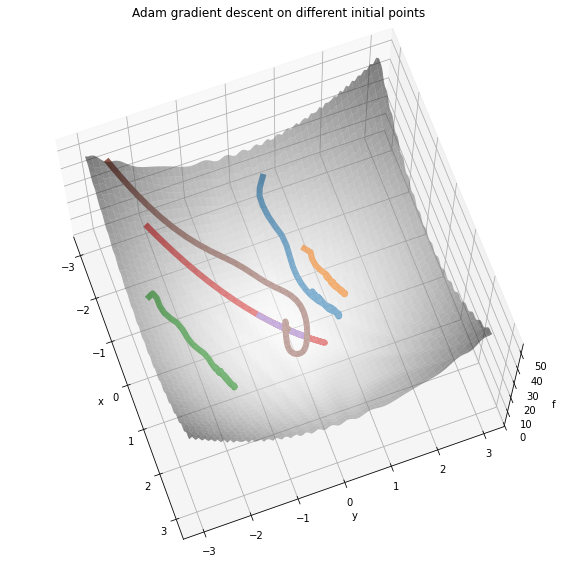

In [66]:
#3d plots
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1, 1, projection='3d') 

ax.set_title('Adam gradient descent on different initial points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f')

sample_traj_1 = []
sample_traj_2 = []
sample_traj_3 = []
sample_traj_4 = []
sample_traj_5 = []

points = [[1,8], [4,9], [5,1], [2,2], [6,6], [0,1]]


for point in range(len(points)):
    sample_traj = []
    xs = []
    ys = []
    zs = []
    for k in range(len(trajectories[5][0][0])):

        x = [trajectories[5][points[point][0]][points[point][1]][k][0]]
        y = [trajectories[5][points[point][0]][points[point][1]][k][1]]            

        temp = surf_2(trajectories[5][points[point][0]][points[point][1]][k][0],
                      trajectories[5][points[point][0]][points[point][1]][k][1], q2)
        z = [temp]

        zs.append(z[0])
        xs.append(x[0])
        ys.append(y[0])

        point_to_plot = np.concatenate((np.asarray(x), np.asarray(y), np.asarray(z)), axis=0)
        sample_traj.append(point_to_plot)

    ax.plot(xs,ys,zs,linewidth=6.0)

Xp = np.linspace(-3, 3, 100)
Yp = np.linspace(-3, 3, 100)
xm, ym = np.meshgrid(Xp, Yp)
Z = surf_2(xm, ym, q2)

surf = ax.plot_surface(xm,ym,Z, cmap = cm.binary, alpha=0.5)
ax.view_init(70, 340)

plt.show() 

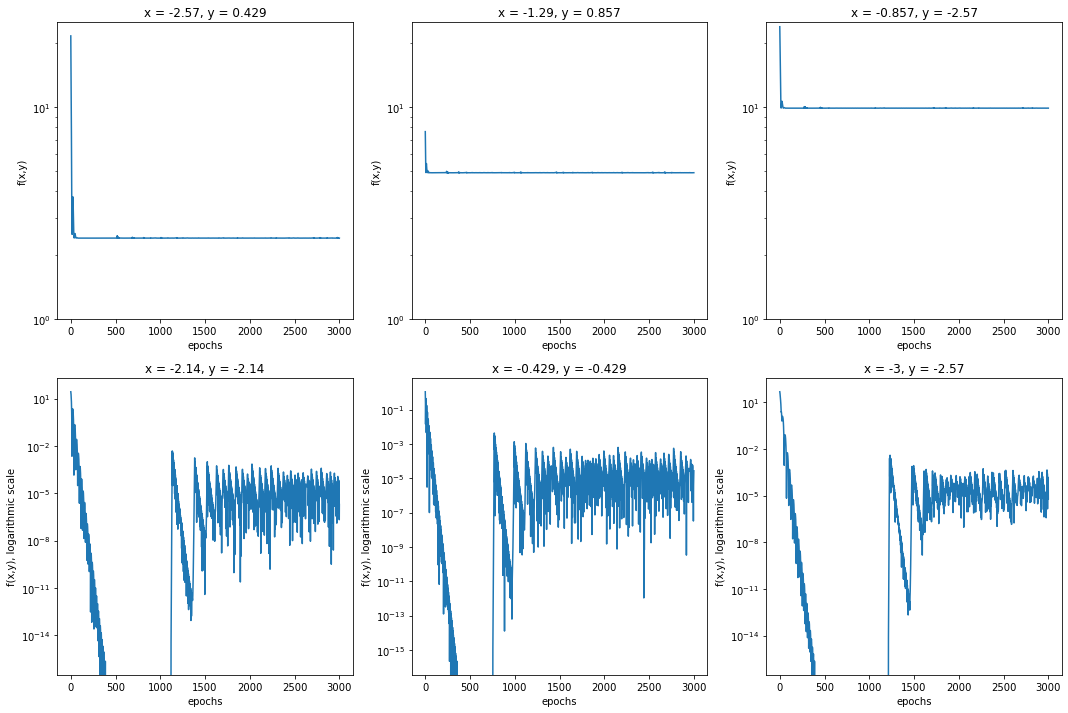

In [67]:
fig, ax = plt.subplots(2,3, figsize=(18,12))

counter = 0

for point in range(len(points)):
    z_2d = []
    for k in range(len(trajectories[5][0][0])):
        z_2d.append(surf_2(trajectories[5][points[point][0]][points[point][1]][k][0],
                          trajectories[5][points[point][0]][points[point][1]][k][1], q2))
    if counter <=2:
        ax[0][counter].plot(z_2d)
        title = 'x = ' + '{0:.3g}'.format(X[points[point][0]]) + ', y = ' + '{0:.3g}'.format(Y[points[point][1]])
        ax[0][counter].set_title(title)
        ax[0][counter].set_yscale('log')
        ax[0][counter].set_xlabel('epochs')
        ax[0][counter].set_ylabel('f(x,y)')
        ax[0][counter].set_ylim(1, 25)
        
    else:
        ax[1][counter-3].plot(z_2d)
        title = 'x = ' + '{0:.3g}'.format(X[points[point][0]]) + ', y = ' + '{0:.3g}'.format(Y[points[point][1]])
        ax[1][counter-3].set_title(title)  
        ax[1][counter-3].set_yscale('log')
        ax[1][counter-3].set_xlabel('epochs')
        ax[1][counter-3].set_ylabel('f(x,y), logarithmic scale')
        

        
    counter +=1
plt.show()

We identify two different behaviours: 

In the first row we report the trajectories that stop stably at a local minimum and will then not reach the global one. 
In the bottom row are instead shown the initial points that, at first, come close to the global minimum but then they jump out and are lead to a fluctuating behaviour around a local minimum.
